In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Steps
# 1. Load and normalize CIFAR-10 (+)
# 2. Define a CNN (+)
# 3. Define loss func (+)
# 4. Train the network training data ()
# 5. Test model with test data ()

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [7]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root=".datasets/cifar10_dataset",
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root=".datasets/cifar10_dataset",
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


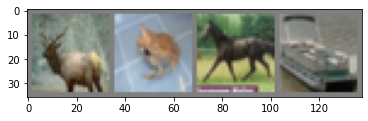

 deer  frog horse  ship


In [10]:
# Presentation
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# Get random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [22]:
# Define NN
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Do not forget this line
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
net = Net()

In [24]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
# Train the NN
for epoch in range(2): # loop over DATASET!!
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # data is [inputs, label] pair
        inputs, labels = data
        
        # zero optimizer
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini batches
            print("[%d, %5d] loss: %.3f" % 
                  (epoch + 1, i + 1, running_loss / 2000)
                 )
            running_loss = 0.0
print("Finished")

[1,  2000] loss: 2.227
[1,  4000] loss: 1.861
[1,  6000] loss: 1.657
[1,  8000] loss: 1.576
[1, 10000] loss: 1.514
[1, 12000] loss: 1.469
[2,  2000] loss: 1.415
[2,  4000] loss: 1.382
[2,  6000] loss: 1.364
[2,  8000] loss: 1.325
[2, 10000] loss: 1.333
[2, 12000] loss: 1.320
Finished


In [29]:
# Save weigths
PATH = "simple_nn_cifar_10.pth"
torch.save(net.state_dict(), PATH)

In [30]:
# Load weights
PATH = "freezed_weights/simple_nn_cifar_10.pth"
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog  bird horse  ship


In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 64.0 %
Accuracy for class car   is: 69.7 %
Accuracy for class bird  is: 32.6 %
Accuracy for class cat   is: 32.1 %
Accuracy for class deer  is: 27.0 %
Accuracy for class dog   is: 53.8 %
Accuracy for class frog  is: 69.0 %
Accuracy for class horse is: 63.8 %
Accuracy for class ship  is: 58.5 %
Accuracy for class truck is: 70.6 %
